# Just a nice stacking ensemble model...

In [22]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import itertools

import xgboost as xgb

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline  

In [23]:
use_xgb=True #disable for speed

datadir="./input/"
cachedir="./cache/"
print(check_output(["ls", datadir]).decode("utf8"))
#print(check_output(["ls", cachedir]).decode("utf8"))



# XGB!

#my first tries:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}
#params from:
#https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 10,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.001,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}


test.csv
test.csv.zip
test_data_all_features.csv
test_data_cats.csv
test_data_conts.csv
test_data_new.csv
test_data_orig_only.csv
train.csv
train.csv.zip
train_data_all_features.csv
train_data_cats.csv
train_data_conts.csv
train_data_new.csv
train_data_orig_only.csv



In [24]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [25]:
def prepdata(data_name,verbose=False):
    ### and now, let's import the data
    data = loadData(datadir,'train_data_'+data_name+'.csv')
    if verbose==True:
        display(data.info())
        display(data.head(2))

    test_data= loadData(datadir,'test_data_'+data_name+'.csv') 
    if verbose==True:
        display(test_data.info())
        display(test_data.head(2))
    # we don't want the ID columns in X
    x=data.drop(['id','loss'],1).values
    # loss is our label
    #y=data['loss'].values
    y = np.log(data['loss']+shift).ravel()

    return x,y,test_data

In [26]:

def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

In [27]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [28]:
def kmeansPlusmeanshift_quick(data):  # used the one above to get the # of clusters, using this for speed
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [29]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(cachedir+filename):
        print filename," exists, importing "
        return joblib.load(cachedir+filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        print("debug 1")
        grid_search.fit(x,y)
        print "debug2"
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,cachedir+filename) 
    return regr

###  Pre Proccessing

In [9]:
shift=200

data_name='all_features'
x,y,test_data=prepdata(data_name)
x_test_data=test_data.drop(['loss','id'],1).values# didn't have the loss column before, make it go away! don't need ID!

loading: ./input/train_data_all_features.csv
Dataset has 188318 samples with 135 features each.
loading: ./input/test_data_all_features.csv
Dataset has 125546 samples with 135 features each.


In [15]:
#prepare the fold divisions --should move this somewhere else...should make an effor to keep consistent in each file

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 188318
folds at: [(0, 37663), (37663, 75326), (75326, 112989), (112989, 150652), (150652, 188318)]
fold size: 37663
train size: 150652
188318


### load layer 1 results

In [16]:
#x_layer2=joblib.load(cachedir+'x_layer2_w_clusters.npy') 


x_layer2=joblib.load(cachedir+'x_layer2_train_final.npy') 


### train layer 2

In [17]:
# grid search on layer 2

        
start_time0 = time.time()

paramater_grid_Lin=dict(normalize = [True,False])
layer2_Lin_regr=grid_search_wrapper(x_layer2,y,LinearRegression(),paramater_grid_Lin,regr_name='L2_Lin')   

paramater_grid_KNN=dict(n_neighbors=[2,5,7,15,30],
                    leaf_size =[3,10,15,25,30,50,100])
layer2_KNN_regr=grid_search_wrapper(x_layer2,y,KNeighborsRegressor(n_jobs = -1),paramater_grid_KNN,regr_name='L2_KNN')   
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_L2_Lin.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
grid_L2_KNN.pkl  exists, importing 
Full GridSearch run time:0.003s


In [12]:
dtrain = xgb.DMatrix(x_layer2, label=y)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))

[0]	train-mae:7.22685+0.0019794	test-mae:7.22685+0.00597406
[100]	train-mae:2.64561+0.00072855	test-mae:2.64564+0.00415248
[200]	train-mae:0.979271+0.000333905	test-mae:0.979988+0.00335506
[300]	train-mae:0.47022+0.000230109	test-mae:0.47731+0.00190486
[400]	train-mae:0.372556+0.000171478	test-mae:0.385569+0.000494569
[500]	train-mae:0.35583+0.000129489	test-mae:0.372391+0.000108223
[600]	train-mae:0.351263+0.000186187	test-mae:0.370545+0.000242282
[700]	train-mae:0.348884+0.000133605	test-mae:0.370312+0.000289885
[800]	train-mae:0.346871+0.000104222	test-mae:0.370283+0.000300949
CV time:340.459s
CV-Mean: 0.37028075+0.000297760285297


In [13]:
display(layer2_Lin_regr)
display(layer2_KNN_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
          weights='uniform')

In [18]:
x_layer3 = []
MAE_tracking=[]


for fold_start,fold_end in folds:
    print("Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    
    X_layer2_validation = x_layer2[fold_start:fold_end].copy()
    y_layer2_validation = y[fold_start:fold_end].copy()
    X_layer2_train=np.concatenate((x_layer2[:fold_start], x_layer2[fold_end:]), axis=0)
    y_layer2_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_layer2_validation),len(X_layer2_train))
    

    layer2_Lin_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_linear=layer2_Lin_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_linear - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_linear) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("LinearRegression Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_Lin_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = layer2_predict_linear
    #with LinearReg: Mean abs error: 1172.67

    #KNeighborsRegressor
    layer2_KNN_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_KNeighbors=layer2_KNN_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_KNeighbors - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_KNeighbors) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('KNNLayer2'),MAE])
    print("KNeighborsRegressor Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_KNN_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = np.column_stack((fold_result,layer2_predict_KNeighbors))  

    #Mean abs error: 1291.64

    # The XGB version of layer 2
    dtrain = xgb.DMatrix(X_layer2_train, label=y_layer2_train)
    dtest = xgb.DMatrix(X_layer2_validation)
    layer2_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)
    
    # now do a prediction and spit out a score(MAE) that means something
    start_time = time.time()
    layer2_gbdt_predict=layer2_gbdt.predict(dtest)
    #MAE=np.mean(abs(layer2_gbdt_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_gbdt_predict) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
    print("XGB Mean abs error: {:.2f}".format(MAE))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
    fold_result = np.column_stack((fold_result,layer2_gbdt_predict))  
    
    #XGB Mean abs error: 1154.25
    
    # ? average those weighted to XGB
    layer2_avg_predict=(layer2_predict_linear+layer2_predict_KNeighbors+layer2_gbdt_predict+layer2_gbdt_predict)/4

    #MAE=np.mean(abs(layer2_avg_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_avg_predict) - np.exp(y_layer2_validation)))

    print("AVG Mean abs error: {:.2f}".format(MAE))
    fold_result = np.column_stack((fold_result,layer2_avg_predict))  

    #AVG Mean abs error: 1163.71
    
    if x_layer3 == []:
        x_layer3=fold_result
    else:
        x_layer3=np.append(x_layer3,fold_result,axis=0)

Fold:0 to 37663 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1134.93
Score: 0.58
KNeighborsRegressor Mean abs error: 1407.55
Score: 0.37
XGB Mean abs error: 1138.08
XGB predict time:1.141s
AVG Mean abs error: 1167.03
Fold:37663 to 75326 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1130.06
Score: 0.58
KNeighborsRegressor Mean abs error: 1395.76
Score: 0.38
XGB Mean abs error: 1133.18
XGB predict time:1.058s
AVG Mean abs error: 1164.32
Fold:75326 to 112989 of: 188318

folding! len test 37663, len train 150655


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:69: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


LinearRegression Mean abs error: 1146.96
Score: 0.57
KNeighborsRegressor Mean abs error: 1408.63
Score: 0.37
XGB Mean abs error: 1147.69
XGB predict time:1.106s
AVG Mean abs error: 1175.99
Fold:112989 to 150652 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1138.54
Score: 0.57
KNeighborsRegressor Mean abs error: 1405.27
Score: 0.37
XGB Mean abs error: 1141.26
XGB predict time:1.226s
AVG Mean abs error: 1169.88
Fold:150652 to 188318 of: 188318

folding! len test 37666, len train 150652
LinearRegression Mean abs error: 1126.34
Score: 0.58
KNeighborsRegressor Mean abs error: 1389.24
Score: 0.38
XGB Mean abs error: 1129.72
XGB predict time:1.143s
AVG Mean abs error: 1157.16


### Layer 3

In [19]:
#  train/validation split
X_layer3_train, X_layer3_validation, y_layer3_train, y_layer3_validation = train_test_split( x_layer3,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)

In [20]:
# The XGB layer3?
print len(x_layer3)
print len(y)

dtrain = xgb.DMatrix(X_layer3_train, label=y_layer3_train)
dtest = xgb.DMatrix(X_layer3_validation)
layer3_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
layer3_gbdt_predict=layer3_gbdt.predict(dtest)
MAE=np.mean(abs(layer3_gbdt_predict- y_layer3_validation))
MAE=np.mean(abs(np.exp(layer3_gbdt_predict) - np.exp(y_layer3_validation)))
MAE_tracking.append(["run:{}".format('XGBLayer3'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#XGB Mean abs error: 1152.25

188318
188318
XGB Mean abs error: 1150.77
XGB predict time:1.377s


### MAE tracking:

[['run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:XGBLayer3']
 ['1134.93334775' '1407.54960405' '1138.07887499' '1130.05522655'
  '1395.76014196' '1133.17997625' '1146.95833371' '1408.62595844'
  '1147.68933343' '1138.54157623' '1405.27446932' '1141.25876637'
  '1126.34277658' '1389.23519608' '1129.72154407' '1150.77496341']]


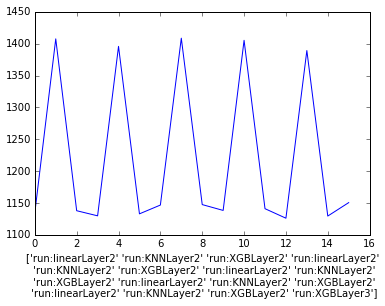

In [21]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)

plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [30]:
# load from file...
x_layer2_test=joblib.load(cachedir+'x_layer2_test_final.npy' ) 


### Layer 2 predictions!

In [34]:
#Linear
start_time = time.time()
layer3_predict_linear=layer2_Lin_regr.predict(x_layer2_test)
print("Linear predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = layer3_predict_linear

#KNeighborsRegressor
start_time = time.time()
layer3_predict_KNeighbors=layer2_KNN_regr.predict(x_layer2_test)
print("KNeighbors predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_predict_KNeighbors))  


# The XGB version of layer 2
dtest = xgb.DMatrix(x_layer2_test)
start_time = time.time()
layer3_gbdt_predict=layer2_gbdt.predict(dtest)
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_gbdt_predict))  


# ? average those weighted to XGB
start_time = time.time()

layer3_avg_predict=(layer3_predict_linear+layer3_predict_KNeighbors+layer3_gbdt_predict+layer3_gbdt_predict)/4
print("AVG predict time:{}s".format(round((time.time()-start_time), 3) ))    

x_layer3_test = np.column_stack((x_layer3_test,layer3_avg_predict))  



Linear predict time:0.01s
KNeighbors predict time:5.85s
XGB predict time:3.552s
AVG predict time:0.002s


In [35]:
#spit out that good scoring linear result...
test_data['loss']=np.exp(layer3_predict_linear)-200


result=test_data[['id','loss',]]
output_fname="result_submission_stack_linear.csv"
display(writeData(result,output_fname))

['id,loss\n',
 '4,1609.37261735\n',
 '6,1880.39514242\n',
 '9,9867.45755099\n',
 '12,6732.20318865\n']

### Predict Layer 3

In [36]:
#the XGB version:
dtest = xgb.DMatrix(x_layer3_test)
test_data['loss']=np.exp(layer3_gbdt.predict(dtest))-200

result=test_data[['id','loss',]]
output_fname="result_submission_stack_xgb.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1631.13012695\n',
 '6,1765.47351074\n',
 '9,9415.92578125\n',
 '12,5387.92675781\n']

In [37]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id      170098.328125
loss      1687.219360
dtype: float32)


# EOF 